# Competition sulla regressione

**A cura di Rigoni Lorenzo e Moretti Riccardo**

## Librerie

In [283]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt

## Caricamento dataset

In [284]:
filePath = './DBs/SolarPark/train.txt'

dataframe = pd.read_csv(filePath)
dataframe.head(5)

,Time Frame,Date,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW)
0,16,3/5/12 4:55 PM,13.01,12.05,52.47,53.08,6.50
1,17,3/5/12 5:55 PM,11.81,8.50,10.41,10.95,0.01
2,18,3/5/12 6:55 PM,10.33,5.68,0.00,0.00,0.00
3,19,3/5/12 7:55 PM,9.66,4.67,0.00,0.00,0.00
4,20,3/5/12 8:55 PM,8.91,3.82,0.00,0.00,0.00


In [285]:
dataframe.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7902 entries, 0 to 7901
Columns: 7 entries, Time Frame to P (kW)
dtypes: float64(5), int64(1), object(1)
memory usage: 432.3+ KB


In [286]:
dataframe.dtypes

Time Frame      int64
Date           object
Ta (C)        float64
Tm (C)        float64
I3 (W/m2)     float64
I15 (W/m2)    float64
P (kW)        float64
dtype: object

## Preprocessing dei dati

Trasformiamo le stringhe delle date in numeri e diminuiamo la precisione dei tipi delle features

In [287]:

datetime_strings = dataframe['Date']
    
# Converte tutte le stringhe in oggetti Timestamp
datetimes = [pd.to_datetime(datetime, format='%m/%d/%y %I:%M %p') for datetime in datetime_strings]
    
# Estrae alcune informazioni dagli oggetti Timestamp
month = [datetime.month for datetime in datetimes]  # Meglio usare il mese se split temporale sequenziale
df_month = pd.DataFrame(month, columns=['Month'])
yday = [datetime.timetuple().tm_yday for datetime in datetimes]
df_yday = pd.DataFrame(yday, columns=['DayOfYear'])

dataframe = dataframe.merge(df_month, left_index=True, right_index=True)
dataframe = dataframe.merge(df_yday, left_index=True, right_index=True)
dataframe = dataframe.drop(columns=['Date'])

dataframe

,Time Frame,Ta (C),Tm (C),I3 (W/m2),I15 (W/m2),P (kW),Month,DayOfYear
0,16,13.01,12.05,52.47,53.08,6.50,3,65
1,17,11.81,8.50,10.41,10.95,0.01,3,65
2,18,10.33,5.68,0.00,0.00,0.00,3,65
3,19,9.66,4.67,0.00,0.00,0.00,3,65
4,20,8.91,3.82,0.00,0.00,0.00,3,65
...,...,...,...,...,...,...,...,...
7897,2,0.00,0.00,0.00,0.00,0.00,2,32
7898,3,0.00,0.00,0.00,0.00,0.00,2,32
7899,4,10.25,6.83,0.00,0.00,0.00,2,33
7900,5,10.54,8.06,0.00,0.00,0.00,2,33


In [288]:
# Calcolo dei coefficienti di correlazione tra le features
corr_matrix = dataframe.corr(numeric_only=True)

# Stampa dei coefficienti di correlazione tra le features e "P (kW)"
print(corr_matrix["P (kW)"].sort_values(ascending = False))

P (kW)        1.000000
I3 (W/m2)     0.986053
I15 (W/m2)    0.985978
Tm (C)        0.720901
Ta (C)        0.565826
Month        -0.066333
DayOfYear    -0.067027
Time Frame   -0.176942
Name: P (kW), dtype: float64


In [289]:
dataframe.drop(columns=['Month', 'DayOfYear'], inplace=True)

In [290]:
dataframe.dtypes

Time Frame      int64
Ta (C)        float64
Tm (C)        float64
I3 (W/m2)     float64
I15 (W/m2)    float64
P (kW)        float64
dtype: object

## Data exploration

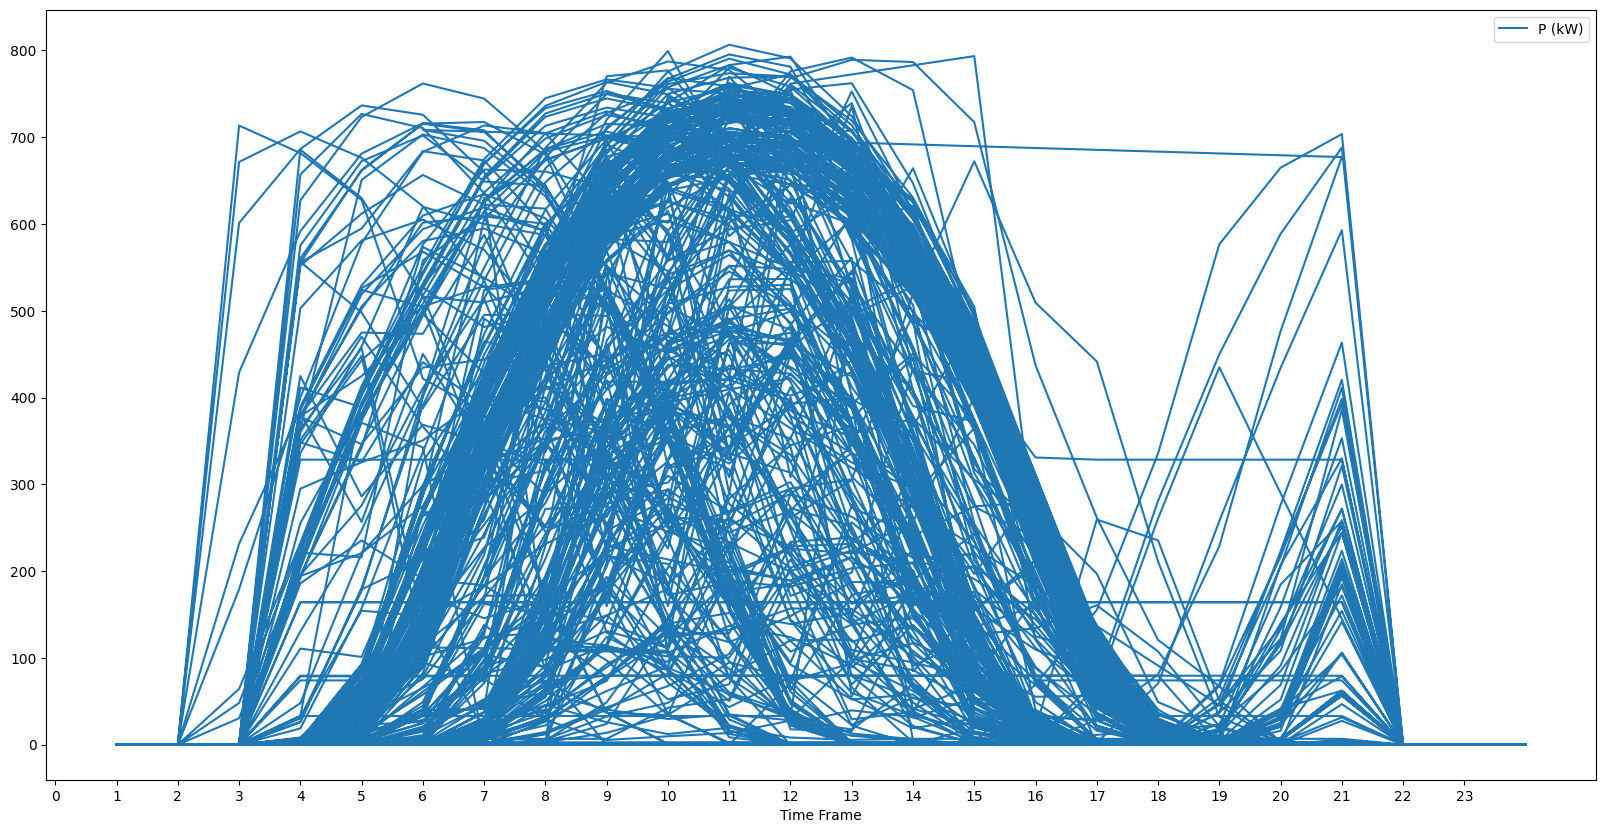

In [291]:
#plot with Time Frame on x, P (kW) on y with 24 hours in the x
dataframe.plot(x='Time Frame', y='P (kW)', figsize=(20, 10))
plt.xticks(ticks=range(0, 24))
plt.show()

In [292]:
dataframe[(dataframe['Time Frame'] <= 2) | (dataframe['Time Frame'] >=22)]['P (kW)'].sum()

np.float64(0.0)

<Axes: >

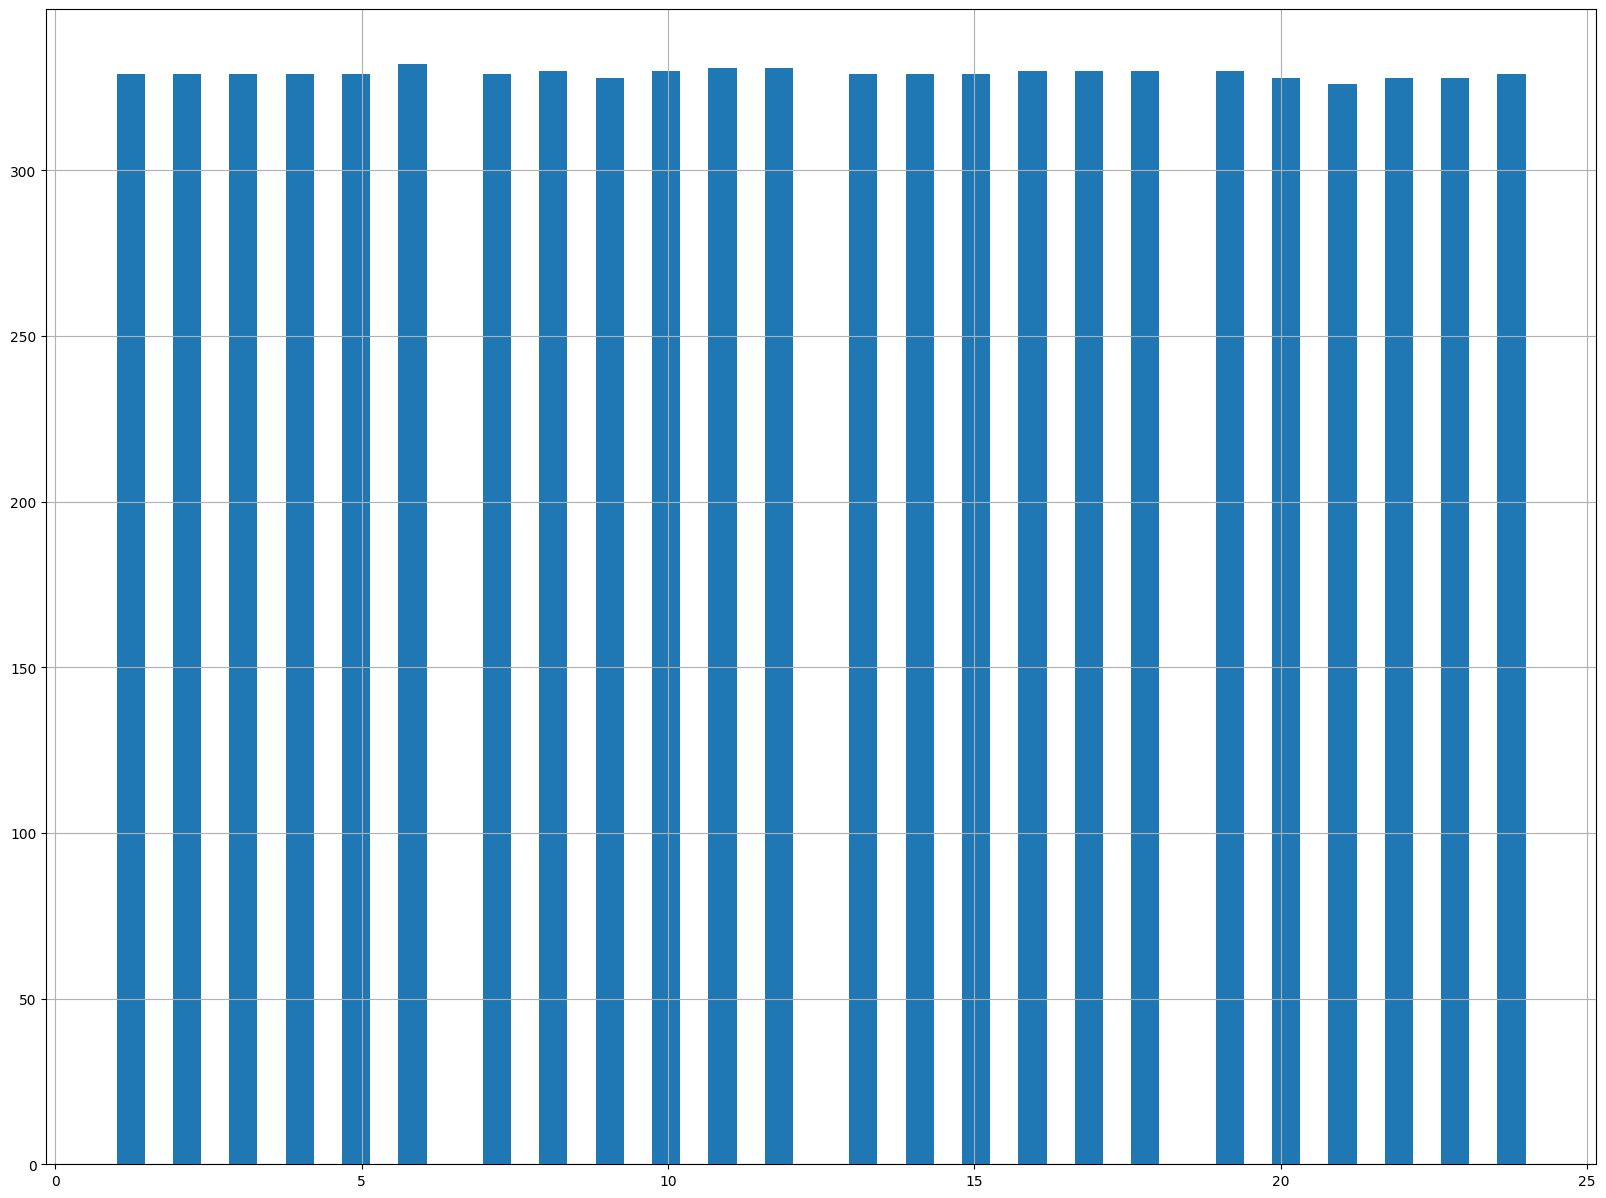

In [293]:
#analisi di Time Frame
dataframe['Time Frame'].hist(bins=50, figsize=(20, 15))

In [294]:
dataframe.isna().sum()

Time Frame    0
Ta (C)        0
Tm (C)        0
I3 (W/m2)     0
I15 (W/m2)    0
P (kW)        0
dtype: int64

Vedendo gli istogrammi, ci sono dei casi anomali con dei picchi sullo 0 nelle varie features. Andiamo a vedere nel dettaglio i pattern di questi valori.

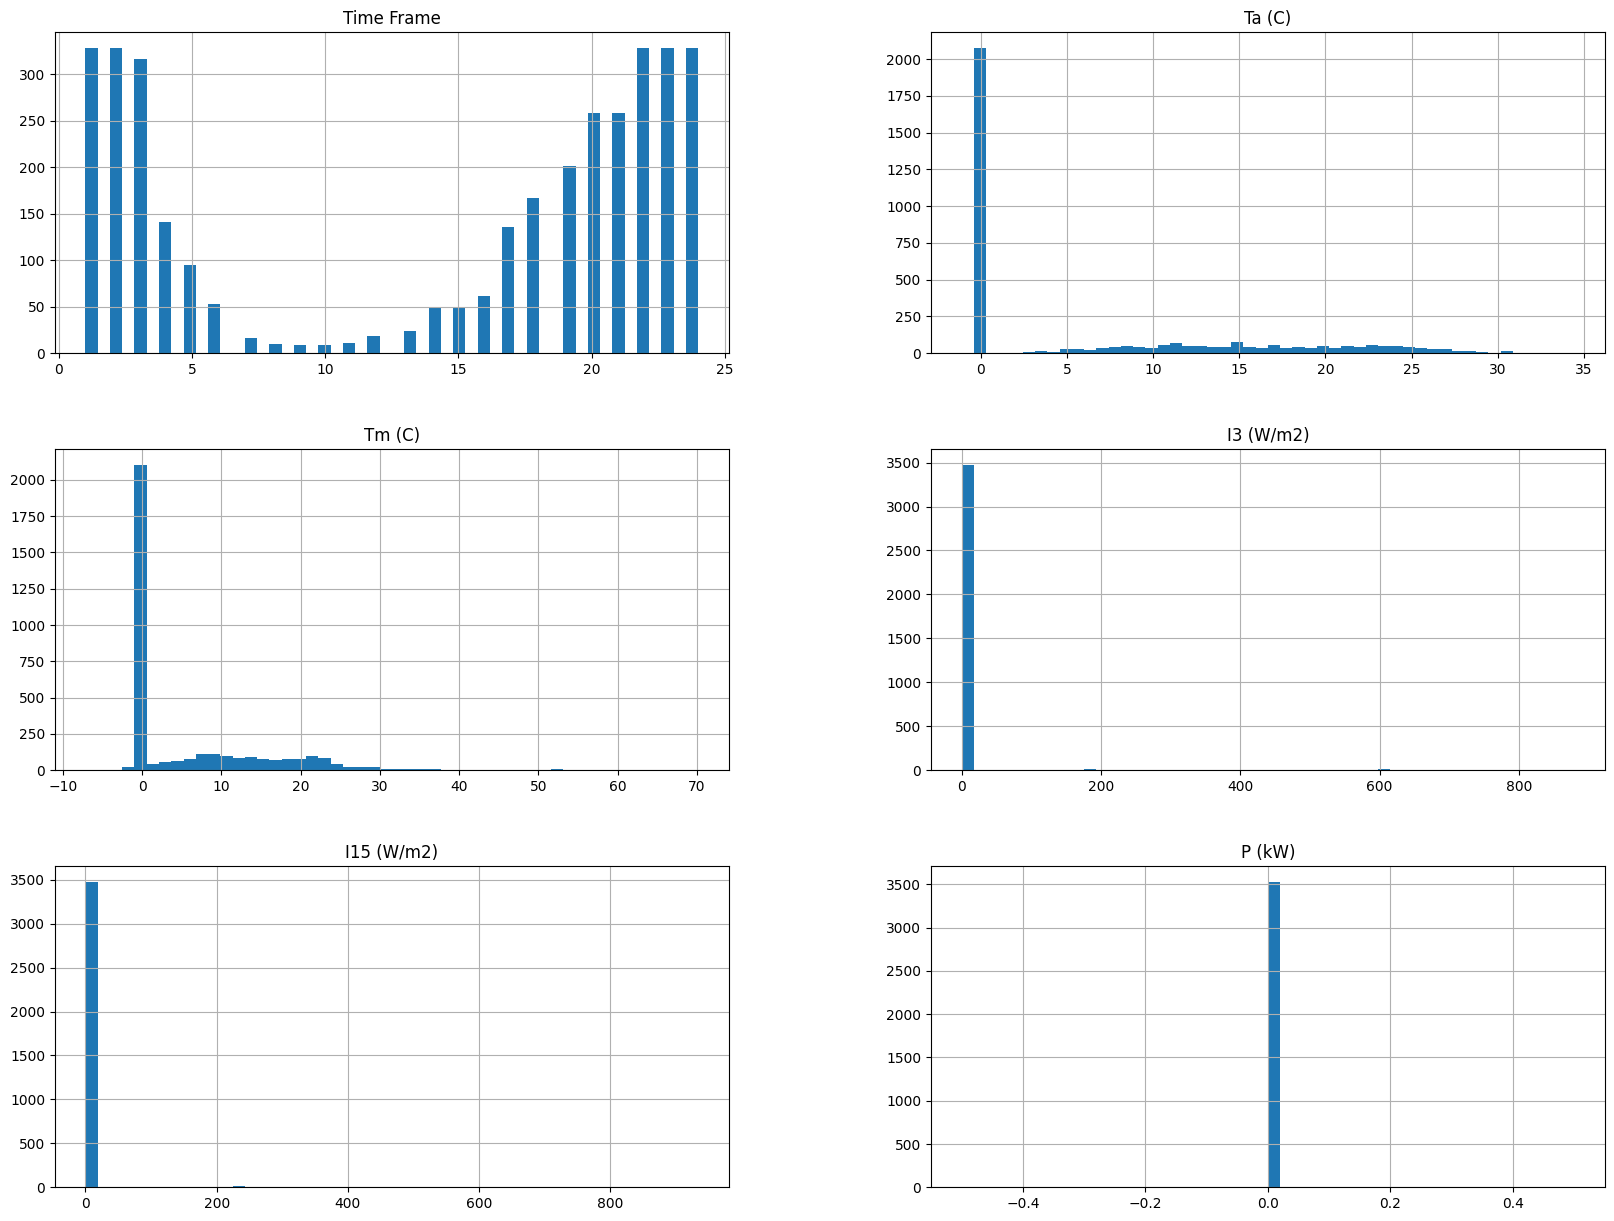

In [295]:
dataframe[(dataframe['P (kW)'] == 0)].hist(bins=50, figsize=(20, 15))
plt.show()

<Axes: >

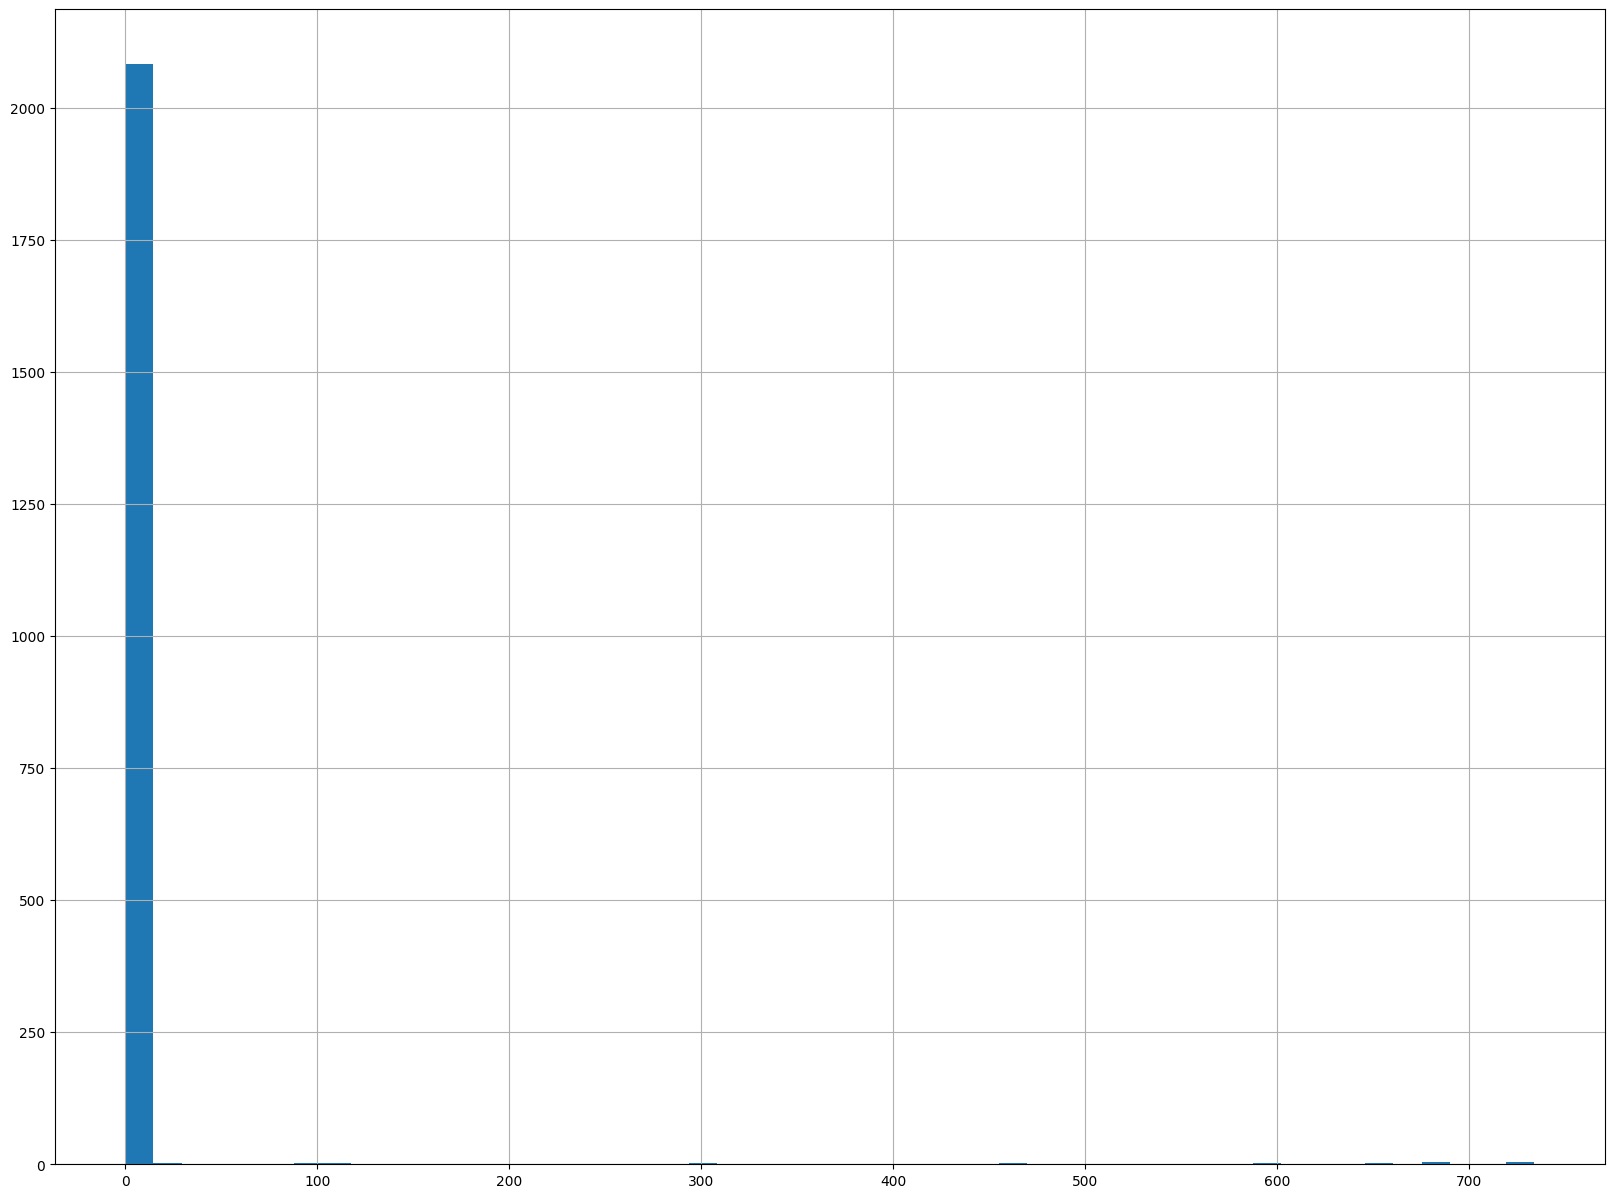

In [296]:
dataframe[(dataframe['Ta (C)'] == 0)]['P (kW)'].hist(bins=50, figsize=(20, 15))

In [297]:
#percentuale di istanze con temperature rilevate pari a 0.
print(f"{len(dataframe[(dataframe['Ta (C)'] == 0) & (dataframe['Tm (C)'] == 0)])/len(dataframe)*100:.1f}%")
#percentuale di istanze con temperature rilevate pari a 0 e potenza pari a 0
print(f"{len(dataframe[(dataframe['Ta (C)'] == 0) & (dataframe['Tm (C)'] == 0) & (dataframe['P (kW)'] == 0)])/len(dataframe)*100:.1f}%")

26.9%
26.3%


In [298]:
#percentuale di istanze con tempo tra le 22e le 4
print(f"{len(dataframe[(dataframe['Time Frame'] >= 22) | (dataframe['Time Frame'] <= 4)])/len(dataframe)*100:.1f}%")
#percentuale di istanze con tempo tra le 22e le 4 e potenza pari a 0
print(f"{len(dataframe[(dataframe['Time Frame'] >= 22) | (dataframe['Time Frame'] <= 4) & (dataframe['P (kW)'] == 0)])/len(dataframe)*100:.1f}%")
print("Sembra esserci correlazione, fare una fuznione tipo hogrider che massimissi la correlazione") 

29.1%
26.6%
Sembra esserci correlazione, fare una fuznione tipo hogrider che massimissi la correlazione


In [299]:
#percentuale di istanze con temperature rilevate minori a 0.
print(f"{len(dataframe[(dataframe['Ta (C)'] < 0) & (dataframe['Tm (C)'] < 0)])/len(dataframe)*100:.1f}%")
#percentuale di istanze con temperature rilevate minori a 0 e potenza pari a 0
print(f"{len(dataframe[(dataframe['Ta (C)'] < 0) & (dataframe['Tm (C)'] < 0) & (dataframe['P (kW)'] == 0)])/len(dataframe)*100:.1f}%")
print("non possiamo trarre conclusioni se non considerare <0 come anomalia")

0.1%
0.0%
non possiamo trarre conclusioni se non considerare <0 come anomalia


In [300]:
#percentuale di istanze con irraggiamento pari a 0.
print(f"{len(dataframe[(dataframe['I3 (W/m2)'] == 0)])/len(dataframe)*100:.1f}%")
#percentuale di istanze con irraggiamento pari a 0 e potenza pari a 0
print(f"{len(dataframe[(dataframe['I3 (W/m2)'] == 0) & (dataframe['P (kW)'] == 0)])/len(dataframe)*100:.1f}%")

45.1%
43.7%


In [301]:
#percentuale di istanze con irraggiamento 15 gradi pari a 0.
print(f"{len(dataframe[(dataframe['I15 (W/m2)'] == 0)])/len(dataframe)*100:.1f}%")
#percentuale di istanze con irraggiamento 15 gradi pari a 0 e potenza pari a 0
print(f"{len(dataframe[(dataframe['I15 (W/m2)'] == 0) & (dataframe['P (kW)'] == 0)])/len(dataframe)*100:.1f}%")


44.5%
43.6%


### Eliminiamo tutti i casi tranne quello della temperatura < 0 e ore notturne per ora

In [302]:
#Eliminiamo tutti i casi tranne quello della temperatura < 0 per ora
corr_matrix = dataframe.corr(numeric_only=True)
print(corr_matrix["P (kW)"].sort_values(ascending=False))
print(dataframe.shape)

print(dataframe.shape)
corr_matrix = dataframe.corr(numeric_only=True)
print(corr_matrix["P (kW)"].sort_values(ascending=False))

P (kW)        1.000000
I3 (W/m2)     0.986053
I15 (W/m2)    0.985978
Tm (C)        0.720901
Ta (C)        0.565826
Time Frame   -0.176942
Name: P (kW), dtype: float64
(7902, 6)
(7902, 6)
P (kW)        1.000000
I3 (W/m2)     0.986053
I15 (W/m2)    0.985978
Tm (C)        0.720901
Ta (C)        0.565826
Time Frame   -0.176942
Name: P (kW), dtype: float64


## Modelli di regressione

### LinearRegression

In [303]:
kf = KFold(5, shuffle=False)

In [304]:
from sklearn.model_selection import train_test_split

### Cella per eliminare certi aspetti del dataframe

In [305]:
max =-250000000000

In [310]:
def splitta(dataframeNew):
     X = dataframeNew.values[:, :dataframeNew.shape[1]-1]
     y = dataframeNew.values[:, dataframeNew.shape[1]-1]

     Ktrain_X = X[0:-1, :]
     Ktrain_y = y[1:]

     # Se predict_ahead è True i dati saranno preparati per lo scenario "predict_ahead"
     predict_ahead = True

     if predict_ahead:
     # Sfasa i dati: le prediction sono quelle dell'ora successiva
          data_x = X[0:-1,:]
          data_y = y[1:]
     else:
          data_x = X
          data_y = y

     # Nota: sfasando i dati si perde l'ultimo pattern

     valid_portion = 0.3
     split_random = True

     if split_random:
          # Split casuale di train e validation set
          return  train_test_split(data_x, data_y, test_size=valid_portion, random_state=1)
     else:    
          # Split temporale
          return train_test_split(data_x, data_y, test_size=valid_portion, shuffle=False,random_state=1)

In [316]:
dataframeNew = dataframe.copy()
#2 nuovi attributi Time Sin e Time Cos
dataframeNew['Time Sin'] = np.sin(2*np.pi*dataframeNew['Time Frame']/24)
dataframeNew['Time Cos'] = np.cos(2*np.pi*dataframeNew['Time Frame']/24)
#dataframeNew.drop(columns=['Time Frame'], inplace=True)
#dataframeNew = dataframeNew[~((dataframeNew['I3 (W/m2)'] == 0) & (dataframeNew['I15 (W/m2)'] == 0) & (dataframeNew['P (kW)'] == 0))]
#dataframeNew = dataframeNew[~((dataframeNew['I3 (W/m2)'] == 0) & (dataframeNew['I15 (W/m2)'] == 0) & (dataframeNew['P (kW)'] != 0))]
#dataframeNew = dataframeNew[~((dataframeNew['Ta (C)'] == 0) & (dataframeNew['Tm (C)'] == 0))]
#dataframeNew = dataframeNew[~((dataframeNew['Time Frame'] >= 22) | (dataframeNew['Time Frame'] <= 2))]
#dataframeNew = dataframeNew[~((dataframeNew['I3 (W/m2)'] == 0))]
##dataframeNew = dataframeNew[~((dataframeNew['I15 (W/m2)'] == 0))]
#dataframeNew.drop(columns=['Time Frame'], inplace=True)
#Divisione in target e features
train_x, validation_x, train_y, validation_y = splitta(dataframeNew)
max = esegui(train_x, validation_x, train_y, validation_y,max)

Validation RMSE:  [-0.03615961 -0.04027638 -0.04507594 -0.02109051 -0.02030037]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### FORESTA A CASO

In [ ]:
from sklearn.model_selection import cross_val_score
def esegui(train_x, validation_x, train_y, validation_y,max):
     # Addestramento di un RandomForestRegressor
    forest_reg = RandomForestRegressor(n_estimators=200,random_state=1)   
    forest_reg.fit(train_x, train_y)

    rmse = -np.sqrt(-cross_val_score(forest_reg, train_x, train_y, cv=kf, scoring='neg_mean_squared_error').mean())
    print('Validation RMSE: ', rmse)
    if (rmse) > max:
        max = (rmse)
        best = rmse
        print("Migliorato")
    print("Migliore combinazione: ", max)
    return max

In [267]:
forest_reg = RandomForestRegressor(random_state=1)
param_grid = [
    {'n_estimators': [200], 
     #'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth' : [7],
     'criterion' :[ 'absolute_error'],
     'n_jobs': [-1]}
]
grid_search = GridSearchCV(forest_reg, param_grid= param_grid, 
                               cv=KFold(n_splits=4, shuffle=False), 
                               scoring='neg_mean_squared_error')
grid_search.fit(data_x, data_y)

# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print('RMSE Migliore:\n', -np.sqrt(-grid_search.best_score_))


Best Parameters: {'criterion': 'absolute_error', 'max_depth': 7, 'n_estimators': 200, 'n_jobs': -1}
RMSE Migliore:
 -80.86770200052113
